## Cleaning, EDA and LDA of Submission Dataset

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("posts") \
    .config("spark.dynamicAllocation.executorIdleTimeout", "300s")\
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "2") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1716403081472_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql.functions import (
    to_timestamp, explode, desc, year, count, round, monotonically_increasing_id, col
)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.ml.feature import CountVectorizer, NGram

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Basic Data EDA

In [4]:
# reading in data
data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .load("s3://131313113finalproject/output_fixed.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()
data.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 7
Total Rows: 10372
root
 |-- title: string (nullable = true)
 |-- date_posted: string (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- flare: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- url: string (nullable = true)

DataFrame[title: string, date_posted: string, author: string, id: string, flare: string, num_comments: string, url: string]

Out of a 64 MB ZST File (iterated through on google colab due to smaller size), with over a million rows, only 10,372 posts contained the word 'abortion' in the title. Since it's relativley small, I am going to keep it a csv. 
I am using this to get more familiar with pyspark and to add to the complete exploration and analysis of the Conservative Subreddits discourse towards abortion. 

### Data Cleaning

In [6]:
data.select('title').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|               title|
+--------------------+
|Men Aren't Allowe...|
|Obama's Love Affa...|
|Liberals vs. Cons...|
|Unlike back-alley...|
|The Immorality of...|
|"Obama's ""Mad"" ...|
|Views on Abortion...|
|Stop Hyding! Abor...|
|Speaker Pelosi’s ...|
|"Senator Democrat...|
|Should abortion b...|
|  The New York Ti...|
|"NPR memo to all ...|
|The New Normal on...|
|Is Ron Paul Wrong...|
|Two sides critici...|
|The Obama adminis...|
|"Political Advice...|
|Gov. Christie Vet...|
|Forced Abortion I...|
+--------------------+
only showing top 20 rows

I had to reclean the titles a few times to get spark to be able to read the CSV file into a spark DF correctly. Now they look good minus some spacing and puntuation issues, but pipeline should take care of that.

In [7]:
data.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------------------+-----+-----+------------+--------------------+
|               title|        date_posted|            author|   id|flare|num_comments|                 url|
+--------------------+-------------------+------------------+-----+-----+------------+--------------------+
|Men Aren't Allowe...|2008-09-22 19:01:29|          cldnails|72v18| null|           5|/r/Conservative/c...|
|Obama's Love Affa...|2009-02-28 15:31:43|           PREZman|810zx| null|           0|/r/Conservative/c...|
|Liberals vs. Cons...|2009-03-04 19:10:08|         Ken_Watts|823uf| null|           0|/r/Conservative/c...|
|Unlike back-alley...|2009-03-07 00:10:46|           dan1123|82q6t| null|           0|/r/Conservative/c...|
|The Immorality of...|2009-07-28 14:04:48|IndustrialEngineer|95ard| null|           0|/r/Conservative/c...|
|"Obama's ""Mad"" ...|2009-08-28 02:17:31|         [deleted]|9ew0d| null|           0|/r/Conservative/c...|
|Views on Abortion...|2009-0

In [8]:
# changing the date_posted back to a usable timestamp
data = data.withColumn('date_posted', to_timestamp(data['date_posted']))

# Show the data
data.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------------------+-----+-----+------------+--------------------+
|               title|        date_posted|            author|   id|flare|num_comments|                 url|
+--------------------+-------------------+------------------+-----+-----+------------+--------------------+
|Men Aren't Allowe...|2008-09-22 19:01:29|          cldnails|72v18| null|           5|/r/Conservative/c...|
|Obama's Love Affa...|2009-02-28 15:31:43|           PREZman|810zx| null|           0|/r/Conservative/c...|
|Liberals vs. Cons...|2009-03-04 19:10:08|         Ken_Watts|823uf| null|           0|/r/Conservative/c...|
|Unlike back-alley...|2009-03-07 00:10:46|           dan1123|82q6t| null|           0|/r/Conservative/c...|
|The Immorality of...|2009-07-28 14:04:48|IndustrialEngineer|95ard| null|           0|/r/Conservative/c...|
|"Obama's ""Mad"" ...|2009-08-28 02:17:31|         [deleted]|9ew0d| null|           0|/r/Conservative/c...|
|Views on Abortion...|2009-0

In [9]:
# and changing the ints back to ints
data = data.withColumn('num_comments', data['num_comments'].cast('int'))

# and giving row ID
data = data.withColumn("row_id", monotonically_increasing_id())

data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- date_posted: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- flare: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- row_id: long (nullable = false)

In [10]:
# are people posting the same thing? normally an issue within Reddit..
duplicates = data.groupBy('title').count().filter('count > 1').sort(desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
duplicates.show(truncate = 50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------------------------+-----+
|                                             title|count|
+--------------------------------------------------+-----+
|                                          Abortion|   18|
|Poll: Post-Roe  Large Majorities of Americans C...|    7|
|                        Leftist Abortion Hypocrisy|    5|
|Trump’s antibody treatment was tested using cel...|    5|
|Arrest made in rape of Ohio girl that led to In...|    5|
|          10-year-old girl denied abortion in Ohio|    5|
|U.S. appeals court upholds Texas ban on second-...|    4|
|Billionaire GOP donor calls President Trump 'an...|    4|
|The current state of the pro-abortion movement....|    4|
|                             Opinions on abortion?|    4|
|As Ohio restricts abortions  10-year-old girl t...|    4|
|Three Texas women are sued for wrongful death a...|    4|
|Opinion: Gender Is A Social Construct  But Only...|    4|
|"Debunking Planned Parenthood's ""3%"" Abortion...|    

People are posting the same article, so there are a decent amount of duplicate appearing posts. Normally, I would drop duplicates. However, knowing Reddit, there is probably unique activity happening within each post.
I'm going to check to see if this seems to be happening.

In [12]:
double_post = data.filter(data.title == 'Poll: Post-Roe  Large Majorities of Americans Continue to Favor Substantial Abortion Restrictions')
double_post.select('title', 'author', 'date_posted', 'id', 'num_comments').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-------------------+-------+------------+
|               title|      author|        date_posted|     id|num_comments|
+--------------------+------------+-------------------+-------+------------+
|Poll: Post-Roe  L...|badgarbage61|2023-01-22 16:01:55|10imxcb|           7|
|Poll: Post-Roe  L...|   [deleted]|2023-01-22 19:14:24|10irjjy|           3|
|Poll: Post-Roe  L...|   [deleted]|2023-01-24 18:10:51|10kbw17|          12|
|Poll: Post-Roe  L...|   [deleted]|2023-01-25 15:29:51|10l1afk|           1|
|Poll: Post-Roe  L...|   [deleted]|2023-01-25 21:23:01|10la4vq|           0|
|Poll: Post-Roe  L...|   [deleted]|2023-01-30 00:30:58|10onmjw|           2|
|Poll: Post-Roe  L...|   [deleted]|2023-01-30 13:42:05|10p2hkz|           1|
+--------------------+------------+-------------------+-------+------------+

As you can see, the same article gets posted, but it has different activity each time. I will need the post ID for when I get the comments realted to these posts. Also, if the same article is getting posted a lot it shows that it's important to the conversation, so I am going to keep it.

In [13]:
# for some reason, 2 lines of headers got added in when I read the csv in. They are not present in the csv, so dropping those
data = data.where(data['title'] != 'title')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
recent_data = data.orderBy('date_posted', ascending=False)

# not as many users are deleted in the morst recent data, and there are now 'flared user only posts', which makes viewing it a lot more messy:
recent_data.select("title", "date_posted").show(truncate=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+
|               title|        date_posted|
+--------------------+-------------------+
|"Abortionist Expe...|2023-12-31 19:10:23|
|Ratcheting Up Abo...|2023-12-31 04:51:14|
|Legislators in Br...|2023-12-30 22:41:16|
|Democrats Will Ma...|2023-12-30 16:35:07|
|You can’t just ca...|2023-12-30 15:17:23|
|Democrats Will Ma...|2023-12-30 03:18:28|
|"OBGYN Confirms "...|2023-12-30 03:00:41|
|Biden Targets Pro...|2023-12-30 01:47:07|
|Permanently banne...|2023-12-30 00:46:19|
|Gene Exterminatio...|2023-12-29 19:39:44|
|Abortion facility...|2023-12-29 18:36:38|
|Abortion facility...|2023-12-29 16:19:53|
|Pro-abortion grou...|2023-12-28 13:06:39|
|After years of re...|2023-12-28 02:54:54|
|Abortion Clinic O...|2023-12-28 02:45:22|
|Pro-abortion grou...|2023-12-27 15:24:16|
|Abortion  the gif...|2023-12-27 13:00:35|
|Wisconsin Distric...|2023-12-27 12:28:50|
|Planned Parenthoo...|2023-12-27 04:32:09|
|Legal group fight...|2023-12-27 03:48:27|
+----------

This data ranges from 2008-09-22 - 2023-12-31. Since I have such a wide range of time, and the user activity has more than likey gone up, it's unfair to compare them. I need to get the total posts for the year, to see what percentage of posts contain 'abortion'

In [15]:
# TOTAL POSTS (obtained outside of Spark, on Google Colab)
total_posts_overall = [
    (2008, 109),
    (2009, 1386),
    (2010, 3321),
    (2011, 8264),
    (2012, 28030),
    (2013, 35272),
    (2014, 36812),
    (2015, 36935),
    (2016, 49423),
    (2017, 52231),
    (2018, 67671),
    (2019, 90669),
    (2020, 207024),
    (2021, 183494),
    (2022, 137781),
    (2023, 95441)
]

schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("total_post_count", IntegerType(), True)
])

total_topic_df = spark.createDataFrame(total_posts_overall, schema)

total_topic_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------------+
|year|total_post_count|
+----+----------------+
|2008|             109|
|2009|            1386|
|2010|            3321|
|2011|            8264|
|2012|           28030|
|2013|           35272|
|2014|           36812|
|2015|           36935|
|2016|           49423|
|2017|           52231|
|2018|           67671|
|2019|           90669|
|2020|          207024|
|2021|          183494|
|2022|          137781|
|2023|           95441|
+----+----------------+

In [16]:
# Abortion data
year_df = data.withColumn('year', year('date_posted'))

posts_per_year = year_df.groupBy('year').agg(count('*').alias('count'))

posts_per_year.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+
|year|count|
+----+-----+
|2018|  638|
|2010|   13|
|2011|   34|
|2017|  360|
|2013|  445|
|2020|  748|
|2015|  277|
|2023| 1957|
|2014|  227|
|2012|  188|
|2016|  274|
|2021| 1126|
|2022| 2585|
|2019| 1488|
|2009|   10|
|2008|    1|
+----+-----+

In [17]:
total_posts = posts_per_year.agg(F.sum('count')).collect()[0][0]
# making sure that matches
print("Total count of posts:", total_posts)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total count of posts: 10371

In [18]:
# the dfs joined together (total and containing 'abortion')
joined = total_topic_df.join(posts_per_year, 'year', 'inner')
joined.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------------+-----+
|year|total_post_count|count|
+----+----------------+-----+
|2008|             109|    1|
|2009|            1386|   10|
|2010|            3321|   13|
|2011|            8264|   34|
|2012|           28030|  188|
|2013|           35272|  445|
|2014|           36812|  227|
|2015|           36935|  277|
|2016|           49423|  274|
|2017|           52231|  360|
|2018|           67671|  638|
|2019|           90669| 1488|
|2020|          207024|  748|
|2021|          183494| 1126|
|2022|          137781| 2585|
|2023|           95441| 1957|
+----+----------------+-----+

In [21]:
percent_df = joined.withColumn('Percent', (col('count') / col('total_post_count')) * 100)

percent_df = percent_df.withColumn('Percent', round(percent_df['Percent'], 2))

percent_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------------+-----+-------+
|year|total_post_count|count|Percent|
+----+----------------+-----+-------+
|2008|             109|    1|   0.92|
|2009|            1386|   10|   0.72|
|2010|            3321|   13|   0.39|
|2011|            8264|   34|   0.41|
|2012|           28030|  188|   0.67|
|2013|           35272|  445|   1.26|
|2014|           36812|  227|   0.62|
|2015|           36935|  277|   0.75|
|2016|           49423|  274|   0.55|
|2017|           52231|  360|   0.69|
|2018|           67671|  638|   0.94|
|2019|           90669| 1488|   1.64|
|2020|          207024|  748|   0.36|
|2021|          183494| 1126|   0.61|
|2022|          137781| 2585|   1.88|
|2023|           95441| 1957|   2.05|
+----+----------------+-----+-------+

In [22]:
# setting up to plot
percent_df_pd = percent_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

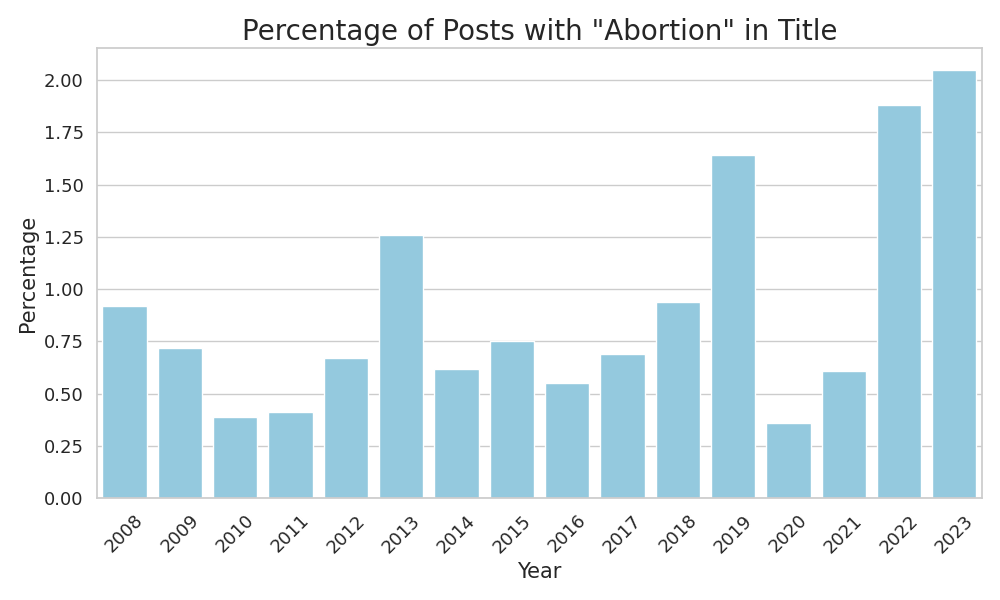

In [23]:
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Percent', data=percent_df_pd, color='skyblue')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.title('Percentage of Posts with "Abortion" in Title', fontsize=20)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.tight_layout()
%matplot plt

As suspected, the SCOTUS leak/ruling in 2022 caused a huge upward trend in abortion posts. It's interesting that there isn't really a pattern to the discussion, though. This might suggest that abortion has remained a topic of political coversation since it became politicized in the 1980s. 

I want to check at a few of the years that I am not sure why they show higher averages.

In [24]:
# checking on 2013, seeing if I can see anything
posts_2013 = data.filter(F.year(data['date_posted']) == 2013)
posts_2013.select('title').show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Shocking Time Magazine Cover: After 40 Years  Abortion Activists Losing                                                                                                                  |
|Shocking Time Magazine Cover: After 40 Years  Abortion Activists Losing | LifeNews.com                                                                                                   |
|I propose an alliance between the Pro-Abortion people and P

In [25]:
# checking on 2019, seeing if I can see anything
posts_2019 = data.filter(F.year(data['date_posted']) == 2019)
posts_2019.select('title').show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                                                                                                                                               |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|'Pro-Life’ Abortion Activist Tells Kids: Abortion Is ‘God’s Plan’                                                 

In [26]:
# didnt see anything out of the ordinary, so going to sample a few times to see if that changes
sample = posts_2013.sample(fraction=.25)
sample.select('title').show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------------------------------------------------------------------+
|title                                                                                                    |
+---------------------------------------------------------------------------------------------------------+
|I propose an alliance between the Pro-Abortion people and Pro-2nd Amendment people                       |
|Pregnancy Centers Gain Influence in Anti-Abortion Arena                                                  |
|"As Senate Candidate  Hagel Opposed Abortion Even In Cases Of Rape Because It Was ""Rare"""              |
|Planned Parenthood reports record year for abortions                                                     |
|More than four in five Americans support major limitations on abortion  poll shows                       |
|Liberal Gene Found: Let the Abortions Begin | The Stir                                                   |
|Gendercide in the UK thanks

In [28]:
sample = posts_2019.sample(fraction=.25)
sample.select('title').show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Abortions leading cause of death worldwide                                                                                                   

There are two major trends seen in these years. First, in 2013 there are a lot of posts pertaining to the criminal trial of Kermit Gosnell, who an abortion doctor turned murderer. 

In 2019, a lot of the discourse seems to center New York passing a Reproductive Health Act, legalizing codifying abortion within the state.

Both of these events seem to have caused an unexpected upward trend.

I am also interested in seeing the most commented on post for each year, as that could tell us something about discourse.

# Starting NLP

In [30]:
# checking to see stopwords
stopwords = StopWordsCleaner().getStopWords()

# adding abortion, bc its mentioned in every title and might throw off model
stopwords.append('abortion')
stopwords.append('abortions')
stopwords.append('im')
stopwords.append('v')
stopwords.append('V')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# setting up pipeline

# creating new col
document_assembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# transforming col
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# taking out stop words
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("stopworded")\
      .setStopWords(stopwords) \
      .setCaseSensitive(False)

# normalizing col
normalizer = Normalizer() \
    .setInputCols(['stopworded']) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# finishing
finisher = Finisher() \
    .setInputCols(["normalized"]) \
    .setOutputCols(["tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            stopwords_cleaner,
            normalizer,
            finisher])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
nlp_model = nlp_pipeline.fit(data)
processed_df  = nlp_model.transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# too messy (bc of how many cols) to look at holistically, just looking at main ones for now
processed_df.select("title", "date_posted", "tokens").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+--------------------+
|               title|        date_posted|              tokens|
+--------------------+-------------------+--------------------+
|Men Aren't Allowe...|2008-09-22 19:01:29|[men, allowed, talk]|
|Obama's Love Affa...|2009-02-28 15:31:43|[obamas, love, af...|
|Liberals vs. Cons...|2009-03-04 19:10:08|[liberals, vs, co...|
|Unlike back-alley...|2009-03-07 00:10:46|[unlike, backalle...|
|The Immorality of...|2009-07-28 14:04:48|[immorality, taxp...|
|"Obama's ""Mad"" ...|2009-08-28 02:17:31|[obamas, mad, sci...|
|Views on Abortion...|2009-09-25 04:31:10|[views, foreign, ...|
|Stop Hyding! Abor...|2009-10-08 18:14:44|[stop, hyding, he...|
|Speaker Pelosi’s ...|2009-11-05 20:02:14|[speaker, pelosis...|
|"Senator Democrat...|2009-11-19 21:22:09|[senator, democra...|
|Should abortion b...|2009-12-23 10:33:52|             [legal]|
|  The New York Ti...|2010-03-12 13:45:03|[new, york, times...|
|"NPR memo to all ...|2010-03-29 17:46:0

In [35]:
print('Total Columns: %d' % len(processed_df.dtypes))
print('Total Rows: %d' % processed_df.count())
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 13
Total Rows: 10371
root
 |-- title: string (nullable = true)
 |-- date_posted: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- flare: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- row_id: long (nullable = false)

In [36]:
tokens_df = processed_df.select('tokens')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# count vectorizing
cv = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=1000, minDF = 5.0)

# fitting model
cv_model = cv.fit(tokens_df)

# transforming
vectorized_tokens = cv_model.transform(tokens_df)

# results, truncating for readibility
vectorized_tokens.select("tokens", "features").show(truncate=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|              tokens|            features|
+--------------------+--------------------+
|[men, allowed, talk]|(1000,[103,479],[...|
|[obamas, love, af...|  (1000,[413],[1.0])|
|[liberals, vs, co...|(1000,[146,166,34...|
|[unlike, backalle...|(1000,[65,321,988...|
|[immorality, taxp...|  (1000,[519],[1.0])|
|[obamas, mad, sci...|  (1000,[453],[1.0])|
|[views, foreign, ...|(1000,[212,377],[...|
|[stop, hyding, he...|(1000,[59,73,81],...|
|[speaker, pelosis...|(1000,[73,266],[1...|
|[senator, democra...|(1000,[73,164,250...|
|             [legal]|   (1000,[65],[1.0])|
|[new, york, times...|(1000,[9,78,96,15...|
|[npr, memo, staff...|(1000,[6,21,232,6...|
|[new, normal, ame...|(1000,[6,9,63],[1...|
|  [ron, paul, wrong]|(1000,[270,495,72...|
|[two, sides, crit...|(1000,[202,951],[...|
|[obama, administr...|(1000,[9,171,190,...|
|[political, advic...|(1000,[21,60,157,...|
|[gov, christie, v...|(1000,[16,39,566,...|
|     [forced, china]|(1000,[149

# Starting LDA

In [39]:
# STARTING LDA
from pyspark.ml.clustering import LDA

num_topics = 10
lda = LDA(k=num_topics, maxIter=100, seed = 13)
model = lda.fit(vectorized_tokens)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, StringType

In [40]:
def printed_topics(lda_model, num_words=10):
    
    words = cv_model.vocabulary
    topics_matrix = lda_model.describeTopics(maxTermsPerTopic=num_words)
    topic_idx = topics_matrix.select("termIndices").rdd.flatMap(lambda x: x).collect()

    topic_words = [[words[idx] for idx in indices] for indices in topic_idx]
    topic_df = spark.createDataFrame(enumerate(topic_words), ["topic", "words"])
    topic_df.show(truncate=False)

printed_topics(model, num_words=10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------------------------------------------------------------------------------------+
|topic|words                                                                                   |
+-----+----------------------------------------------------------------------------------------+
|0    |[biden, proabortion, new, trump, catholic, joe, news, banned, administration, campaign] |
|1    |[murder, rape, child, argument, pro, choice, change, prochoice, ny, good]               |
|2    |[bill, support, birth, democrats, want, americans, house, vote, democrat, poll]         |
|3    |[babies, people, killing, roe, like, lateterm, left, one, think, baby]                  |
|4    |[black, die, baby, uk, business, syndrome, based, west, moral, race]                    |
|5    |[planned, parenthood, women, laws, children, pregnant, clinics, governor, get, babies]  |
|6    |[woman, democrats, kill, pay, travel, virginia, bill, kids, funding, story]             |
|7    |[law, court, ban, texas

In [42]:
# adding on id
vectorized_tokens_with_id = vectorized_tokens.withColumn("doc_id", monotonically_increasing_id())
vectorized_tokens_with_id.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- doc_id: long (nullable = false)

In [43]:
transformed_data = model.transform(vectorized_tokens_with_id)
topic_dist = transformed_data.select("doc_id", "topicDistribution")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
topic_dist_array = topic_dist.withColumn("topicDistribution_ar", vector_to_array(col("topicDistribution")))

mean_prob_columns = [round((F.sum(col(f'topicDistribution_ar')[i]) / 10371), 3).alias(f'Topic {i}') for i in range(10)]

topic_proportions = topic_dist_array \
    .agg(*mean_prob_columns)

topic_proportions = topic_proportions.toPandas()

probs = topic_proportions.values[0]
labels = topic_proportions.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

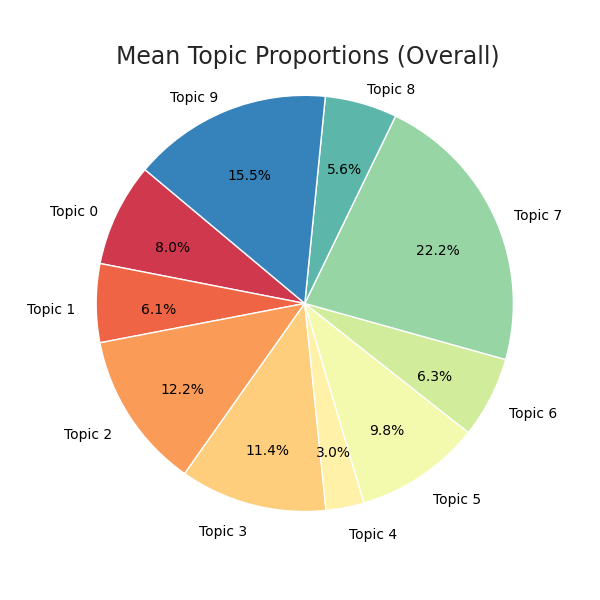

In [74]:
colors = sns.color_palette("Spectral", n_colors=len(labels))

plt.figure(figsize=(6, 6))
wedges, _, autotexts = plt.pie(probs, labels=labels, autopct='%1.1f%%', pctdistance=.7,
                                  startangle=140, colors=colors, textprops={'color': 'black', 'fontsize': 10, 'verticalalignment': 'top'})

plt.legend(labels, loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution of Topics (Overall)', fontsize=17)
plt.axis('equal')
%matplot plt

## Bigrams

In [75]:
# don't need to create an entirely new pipeline, bc I can just use the cols from above
ngram = NGram(n=2, inputCol="tokens", outputCol="bigrams")
pipeline = Pipeline(stages=[ngram])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
pipeline_model = pipeline.fit(vectorized_tokens_with_id)

result = pipeline_model.transform(vectorized_tokens_with_id)

result_exploded = result.select(explode("bigrams").alias("bigram"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
exploded_counts = result_exploded.groupBy('bigram').count()

exploded_counts.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|             bigram|count|
+-------------------+-----+
|   christie advised|    1|
|  gathered national|    1|
|        fetus organ|    1|
|           texas lt|    1|
|    mcauliffe ready|    1|
|   staffer insisted|    1|
|      speech limits|    1|
|          dumb fuck|    1|
|           x videos|    1|
| legislature moving|    1|
| california decides|    1|
|    shocking dallas|    1|
|        gives fiery|    1|
|      group promote|    5|
|         babys neck|    1|
| clears legislature|    1|
|        cyrus posts|    1|
|moderates laughably|    1|
|    francis orourke|    1|
|     reason morally|    1|
+-------------------+-----+
only showing top 20 rows

In [78]:
print('Total Rows: %d' % exploded_counts.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 55824

In [80]:
# 55,824 unique ngrams within the titles..
from pyspark.sql.functions import mean

# looking at mean and med before I decide threshold

mean = exploded_counts.select(mean("count")).first()[0]
med = exploded_counts.stat.approxQuantile('count', [0.5], 0.25)[0]

print('mean:', mean)
print('median:', med)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

mean: 1.3629800802522212
median: 1.0

Because there are so many ngrams, I knew the mean and median would be low. I think that will make the ngrams that do appear multiple times even more noteworthy, though. Because there are so many possibilities, I'm going to set the threshold at 15.

In [81]:
filtered = exploded_counts.filter(exploded_counts['count'] > 15)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
print('Total Bigrams: %d' % filtered.count())
print()
print('Top Bigrams Overall')
filtered.orderBy('count', ascending=False).show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Bigrams: 149

Top Bigrams Overall
+------------------+-----+
|            bigram|count|
+------------------+-----+
|     supreme court|  413|
|planned parenthood|  385|
|          roe wade|  165|
|         texas law|  121|
|    killing babies|   91|
|          new york|   83|
|         joe biden|   83|
|          week ban|   77|
|     kamala harris|   71|
|     appeals court|   67|
|       passes bill|   60|
|        signs bill|   55|
| pregnancy centers|   52|
|       kill babies|   47|
|      bill banning|   47|
|        born alive|   44|
|         texas ban|   44|
|    heartbeat bill|   43|
|    governor signs|   43|
|    south carolina|   42|
+------------------+-----+
only showing top 20 rows

In [83]:
# changing to row ID, so I can join df on common col
vectorized_tokens_with_id = vectorized_tokens_with_id.withColumnRenamed("doc_id", "row_id")
vectorized_tokens_with_id.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- row_id: long (nullable = false)

## Bigrams by Year

In [84]:
# joining df to get bigrams by year
joined_on_year = vectorized_tokens_with_id.join(data, 'row_id', 'inner')
joined_on_year = joined_on_year.withColumn('year', F.year(joined_on_year['date_posted']))

joined_on_year.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- row_id: long (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- title: string (nullable = true)
 |-- date_posted: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- flare: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- year: integer (nullable = true)

In [85]:
# creating func for each year

def ngram_by_year(year):
    
    # filtering by year
    filtered_df = joined_on_year.filter(F.year(joined_on_year['date_posted']) == year)
    
     # creating Ngram pipeline
    ngram = NGram(n=2, inputCol="tokens", outputCol="bigrams")
    pipeline = Pipeline(stages=[ngram])
    pipeline_model = pipeline.fit(filtered_df)

    result = pipeline_model.transform(filtered_df)
    result_exploded = result.select(explode("bigrams").alias("bigram"))
    exploded_counts = result_exploded.groupBy('bigram').count()
    
    filtered = exploded_counts.filter(exploded_counts['count'] > 5)
    
    top_grams = filtered.orderBy('count', ascending=False)
    print(f'Top Bigrams in {year}')
    top_grams.show(10)
    print ('--'*50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
ngram_by_year(2012)
ngram_by_year(2013)
ngram_by_year(2014)
ngram_by_year(2015)
ngram_by_year(2016)
ngram_by_year(2017)
ngram_by_year(2018)
ngram_by_year(2019)
ngram_by_year(2020)
ngram_by_year(2021)
ngram_by_year(2022)
ngram_by_year(2023)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Top Bigrams in 2012
+------------------+-----+
|            bigram|count|
+------------------+-----+
|planned parenthood|   10|
+------------------+-----+

----------------------------------------------------------------------------------------------------
Top Bigrams in 2013
+------------------+-----+
|            bigram|count|
+------------------+-----+
|planned parenthood|   19|
|         late term|   13|
|    kermit gosnell|   12|
|       wendy davis|    8|
|      north dakota|    7|
|     house horrors|    6|
|     xpost prolife|    6|
|     gosnell trial|    6|
+------------------+-----+

----------------------------------------------------------------------------------------------------
Top Bigrams in 2014
+------------------+-----+
|            bigram|count|
+------------------+-----+
|planned parenthood|   14|
|     supreme court|    9|
|      gay marriage|    6|
+------------------+-----+

---------------------------------------------------------------------------------------

## Getting Post IDs

I need the post IDs so that I know which comments to extract from the 2GB compressed ZST file

In [93]:
posts_w_comments = data.filter(data.num_comments > 0)
print('Total Rows: %d' % post_id.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 6573

In [94]:
post_id_lst = posts_w_comments.select('id').rdd.flatMap(lambda x: x).collect()

len(post_id_lst)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6573

In [95]:
posts_w_comments.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+-------------------+-----+-----+------------+--------------------+------+
|               title|        date_posted|             author|   id|flare|num_comments|                 url|row_id|
+--------------------+-------------------+-------------------+-----+-----+------------+--------------------+------+
|Men Aren't Allowe...|2008-09-22 19:01:29|           cldnails|72v18| null|           5|/r/Conservative/c...|     0|
|Should abortion b...|2009-12-23 10:33:52|          [deleted]|ahsop| null|          14|/r/Conservative/c...|    10|
|  The New York Ti...|2010-03-12 13:45:03|          30Seconds|bcj1g| null|           2|/r/Conservative/c...|    11|
|"NPR memo to all ...|2010-03-29 17:46:07|          [deleted]|bjsrb| null|          43|/r/Conservative/c...|    12|
|The New Normal on...|2010-05-14 17:07:09|            dan1123|c45dz| null|           3|/r/Conservative/c...|    13|
|Two sides critici...|2010-06-22 23:27:18|        DeskofBrian|chxh4| nul

In [98]:
bucket = 's3://131313113finalproject/posts_w_comments'

posts_w_comments.write.parquet(bucket, mode="overwrite")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…